## Notebook 2: AG's News Topic Modeling using Latent Dirichlet Allocation

**1. Prepare prolem**

In [1]:
# a) Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load the data
train_df = pd.read_csv('train.csv', delimiter=',', header=None, names=['index', 'title', 'description'])
test_df = pd.read_csv('test.csv', delimiter=',', header=None, names=['index', 'title', 'description'])

**2. Exploratory Data Analysis**

In [3]:
train_df.head()

,index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
test_df.head()

,index,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


The train and test sets each consist of three columns, representing the index (four classes), title, and descriptions.

In [5]:
# Basic statistics
train_df.describe(include='all')

,index,title,description
count,120000.000000,120000,120000
unique,NaN,114364,118731
top,NaN,Today's schedule,"With the economy slowly turning up, upgrading ..."
freq,NaN,39,15
mean,2.500000,NaN,NaN
std,1.118039,NaN,NaN
min,1.000000,NaN,NaN
25%,1.750000,NaN,NaN
50%,2.500000,NaN,NaN
75%,3.250000,NaN,NaN


In [6]:
# Dataset summary
train_vocab_size_before = len(set(word for desc in train_df['description'] for word in desc.split()))
train_word_count_before = sum(len(desc.split()) for desc in train_df['description'])

test_vocab_size_before = len(set(word for desc in test_df['description'] for word in desc.split()))
test_word_count_before = sum(len(desc.split()) for desc in test_df['description'])

print("Training set before cleaning - Vocabulary size: {}, Total word count: {}".format(train_vocab_size_before, train_word_count_before))
print("Test set before cleaning - Vocabulary size: {}, Total word count: {}".format(test_vocab_size_before, test_word_count_before))


Training set before cleaning - Vocabulary size: 156039, Total word count: 3727523
Test set before cleaning - Vocabulary size: 33632, Total word count: 235321


In [7]:
# Count missing values
print(train_df.isna().sum())

# Drop records with missing values
train_df.dropna(inplace=True)

# Fill missing values with a default value
train_df.fillna('Unknown', inplace=True)

index          0
title          0
description    0
dtype: int64


<AxesSubplot: xlabel='index', ylabel='count'>

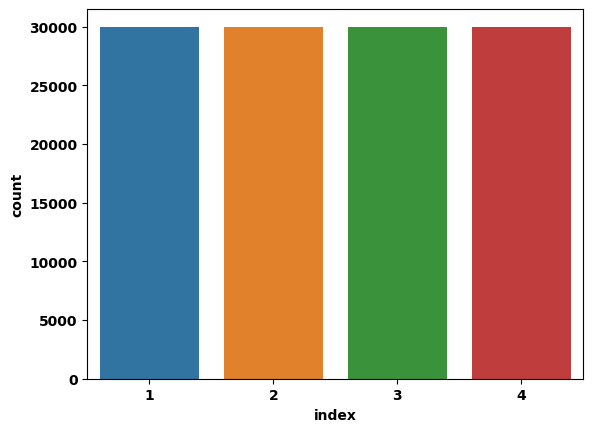

In [8]:
# Class distribution
sns.countplot(x='index', data=train_df)

As evidenced by the plot, the dataset is well-balanced with an equal distribution of classes.

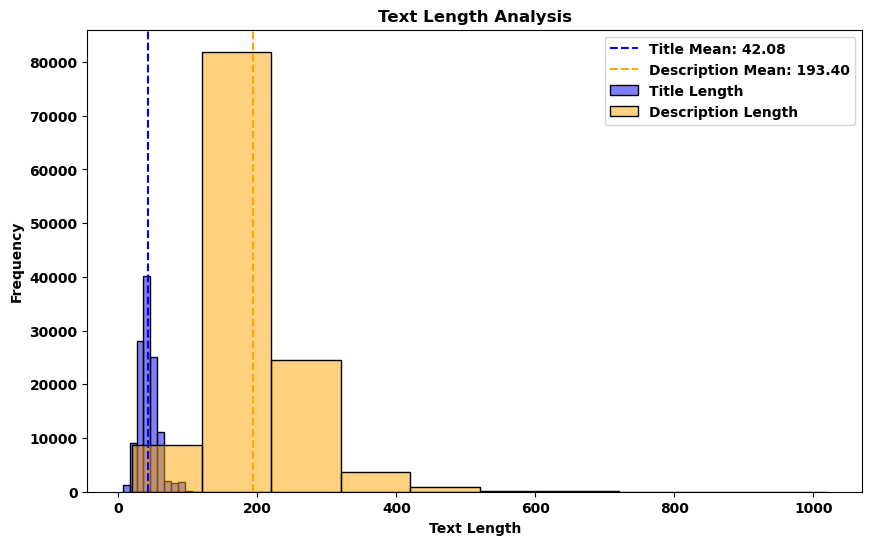

In [9]:
# Text length analysis
train_df['title_length'] = train_df['title'].apply(len)
train_df['description_length'] = train_df['description'].apply(len)

title_mean = np.mean(train_df['title_length'])
desc_mean = np.mean(train_df['description_length'])

plt.figure(figsize=(10, 6))

# Create histogram for title length
sns.histplot(train_df['title_length'], label='Title Length', alpha=0.5, color='blue', binwidth=10)

# Create histogram for description length
sns.histplot(train_df['description_length'], label='Description Length', alpha=0.5, color='orange', binwidth=100)

# Add vertical line for mean title length
plt.axvline(title_mean, color='blue', linestyle='--', label=f"Title Mean: {title_mean:.2f}")

# Add vertical line for mean description length
plt.axvline(desc_mean, color='orange', linestyle='--', label=f"Description Mean: {desc_mean:.2f}")

plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Analysis")
plt.show()

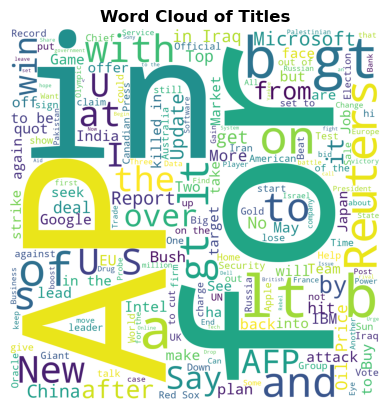

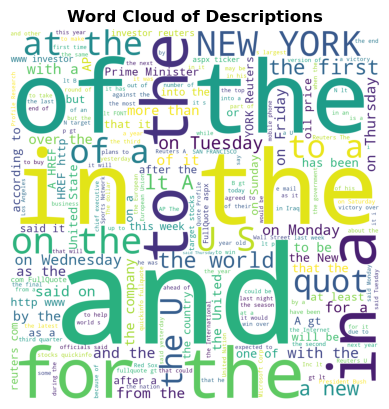

In [10]:
# Word frequency analysis
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=1200, height=1200, background_color='white', stopwords=set()).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

all_titles = ' '.join(train_df['title'].values)
all_descriptions = ' '.join(train_df['description'].values)

plot_wordcloud(all_titles, "Word Cloud of Titles")
plot_wordcloud(all_descriptions, "Word Cloud of Descriptions")

The purpose of N-gram analysis is to capture the language structure from phrases to sentences, and even paragraphs depending on the value of 'n'. It helps to predict the next item in a sequence, particularly in language modelling. 

In this project, 2-gram (bigram) analysis is conducted. The N-gram analysis reveals the most frequently occurring n-grams (sequences of words) within the 'title' and 'description' columns, which aids in identifying common phrases and patterns present in the text data.

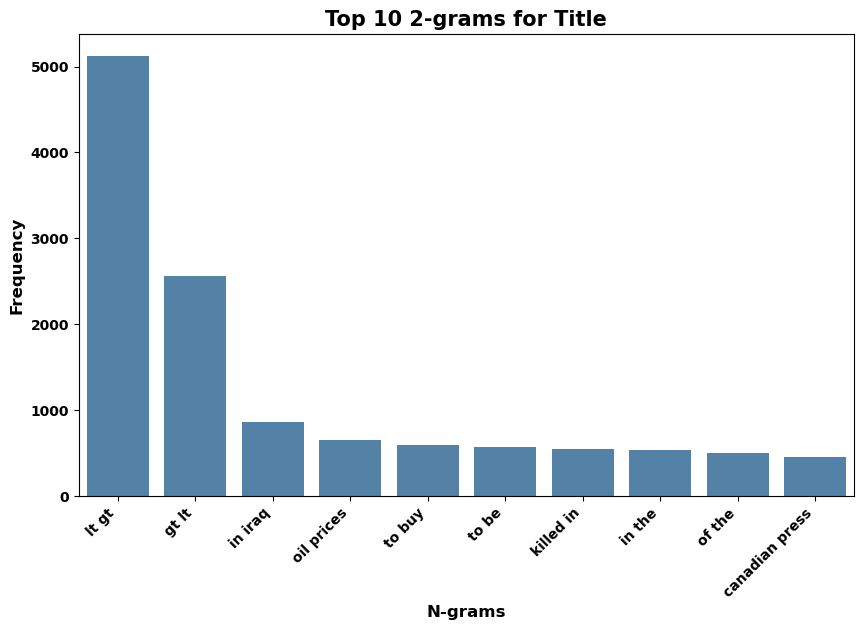

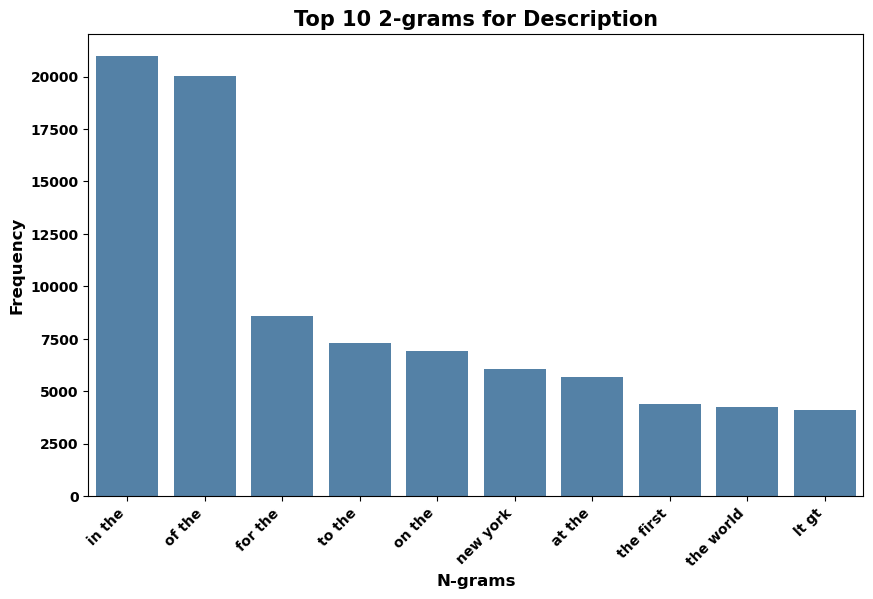

In [11]:
# N-gram analysis
def plot_top_ngrams(corpus, n, g, text_type):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x=[x[0] for x in words_freq], y=[x[1] for x in words_freq], ax=ax, color='steelblue')
    ax.set_xticklabels([x[0] for x in words_freq], rotation=45, ha='right')
    ax.set_xlabel("N-grams", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title(f"Top {n} {g}-grams for {text_type}", fontsize=15)
    plt.show()

plot_top_ngrams(train_df['title'], 10, 2, "Title")
plot_top_ngrams(train_df['description'], 10, 2, "Description")

**3. Prepare Data**

In [12]:
# a) Data cleaning
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [13]:
# Apply clean_doc to each document in the DataFrame
train_df['cleaned_title'] = train_df['title'].apply(clean_doc)
train_df['cleaned_description'] = train_df['description'].apply(clean_doc)

test_df['cleaned_title'] = test_df['title'].apply(clean_doc)
test_df['cleaned_description'] = test_df['description'].apply(clean_doc)

In [14]:
# Dataset after cleaning
train_vocab_size_after = len(set(word for tokens in train_df['cleaned_description'] for word in tokens))
train_word_count_after = sum(len(tokens) for tokens in train_df['cleaned_description'])

test_vocab_size_after = len(set(word for tokens in test_df['cleaned_description'] for word in tokens))
test_word_count_after = sum(len(tokens) for tokens in test_df['cleaned_description'])

print("Training set after cleaning - Vocabulary size: {}, Total word count: {}".format(train_vocab_size_after, train_word_count_after))
print("Test set after cleaning - Vocabulary size: {}, Total word count: {}".format(test_vocab_size_after, test_word_count_after))

Training set after cleaning - Vocabulary size: 97113, Total word count: 2369442
Test set after cleaning - Vocabulary size: 24546, Total word count: 149428


We observe a substantial reduction in the dataset size following the execution of the data cleaning process.

In [15]:
# b) Preprocess the train and test sets
def preprocess(text):
    if not isinstance(text, str):
        return []
    return [token for token in simple_preprocess(text, min_len=3) if token not in STOPWORDS]

def preprocess_data(train_df, test_df):
    train_df['tokens'] = train_df['description'].apply(preprocess)
    test_df['tokens'] = test_df['description'].apply(preprocess)

    return train_df, test_df

train_df, test_df = preprocess_data(train_df, test_df)

In [16]:
# Create a dictionary and bag-of-words corpus for the training dataset
dict_train = Dictionary(train_df['tokens'])
train_corpus = [dict_train.doc2bow(text) for text in train_df['tokens']]

# Update the dictionary with the test dataset tokens
dict_train.add_documents(test_df['tokens'])

**4. Topic Modeling using LDA**

In [17]:
# Define an LDA model on the training dataset
lda_model = LdaModel(corpus=train_corpus, id2word=dict_train, num_topics=10, random_state=42)

In [18]:
# Filter out words from the test corpus that are not in the training corpus
def filter_test_corpus(text):
    return [(word_id, freq) for word_id, freq in dict_train.doc2bow(text) if word_id in lda_model.id2word]

test_corpus = [filter_test_corpus(text) for text in test_df['tokens']]

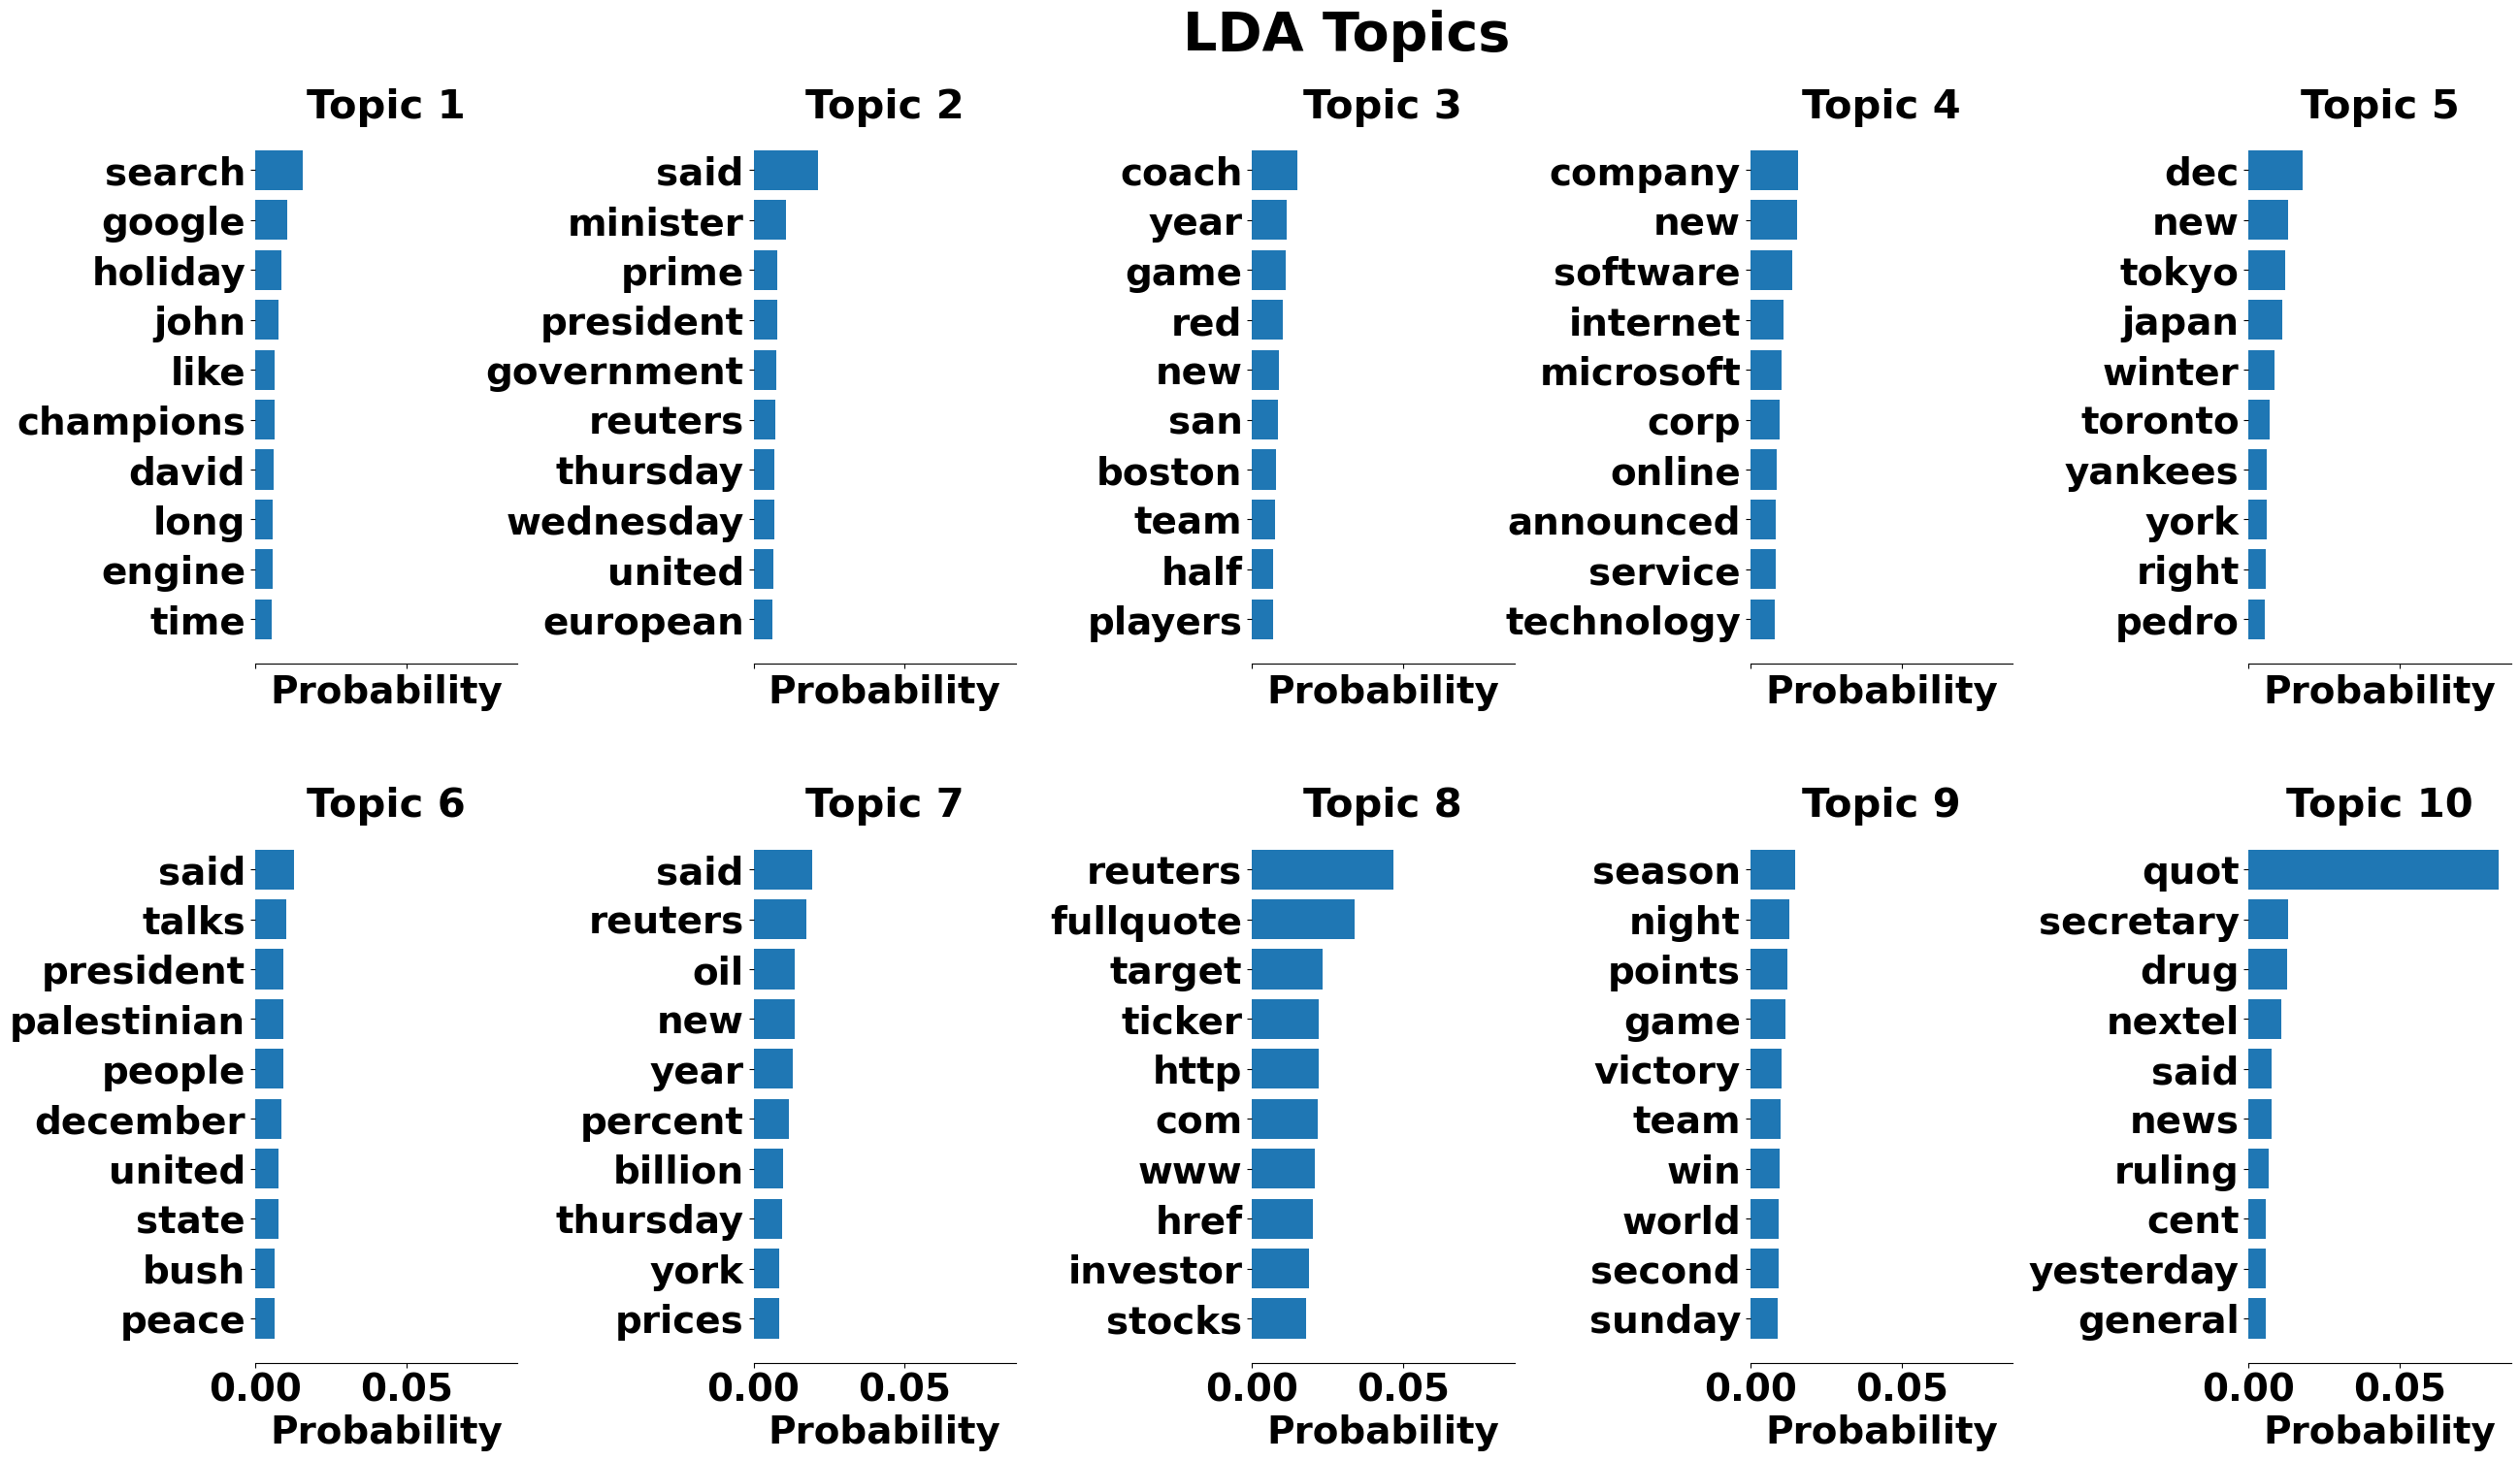

In [19]:
def plot_topic_words(lda_model, num_words=10):
    topics = lda_model.show_topics(formatted=False, num_words=num_words)
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for i, (_, topic_words) in enumerate(topics):
        words, probabilities = zip(*topic_words)
        ax = axes[i]
        ax.barh(words, probabilities)
        ax.set_title(f"Topic {i + 1}", fontsize=30)
        ax.set_xlabel("Probability", fontsize=28)
        ax.tick_params(axis='y', labelsize=28)
        ax.tick_params(axis='x', labelsize=28)
        ax.invert_yaxis()
        for spine in "top right left".split():
            ax.spines[spine].set_visible(False)

    fig.suptitle('LDA Topics', fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_topic_words(lda_model, num_words=10)

In [20]:
# Get the document-topic distribution for the train corpus
doc_topic_distribution = [lda_model.get_document_topics(doc) for doc in train_corpus]

# Convert the distribution to a NumPy array
doc_topic_distribution_array = np.zeros((len(train_corpus), lda_model.num_topics))
for i, doc_topics in enumerate(doc_topic_distribution):
    for topic, probability in doc_topics:
        doc_topic_distribution_array[i, topic] = probability

# Get the most probable topics for each document
most_probable_topics = np.argmax(doc_topic_distribution_array, axis=1)

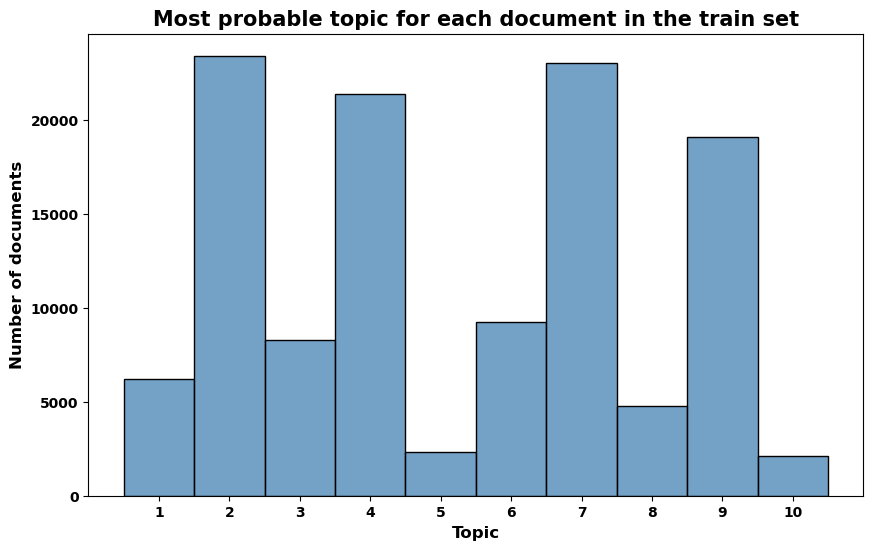

In [21]:
most_probable_topics_adjusted = [topic+1 for topic in most_probable_topics]

plt.figure(figsize=(10, 6))
sns.histplot(most_probable_topics_adjusted, bins=range(1, lda_model.num_topics + 2), 
             color='steelblue', edgecolor='black')

# Adjust x-ticks to range from 1 to 10, shift by 0.5 to place in the center of the bars
plt.xticks(ticks = [i+0.5 for i in range(1, lda_model.num_topics + 1)], 
           labels = range(1, lda_model.num_topics + 1))

plt.title('Most probable topic for each document in the train set', fontsize=15)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of documents', fontsize=12)
plt.show()

Apply the LDA model on the test corpus to obtain topic distributions for each document in the test set.

In [22]:
test_doc_topics = lda_model[test_corpus]

In [23]:
def get_topic_names(lda_model, n_words=3):
    topic_names = []
    for i, topic in enumerate(lda_model.show_topics(formatted=False, num_words=n_words)):
        words, _ = zip(*topic[1])
        topic_names.append(" ".join(words))
    return topic_names

In [24]:
# Get the document-topic distribution for the test corpus
test_doc_topic_distribution = [lda_model.get_document_topics(doc) for doc in test_corpus]

# Convert the distribution to a NumPy array
test_doc_topic_distribution_array = np.zeros((len(test_corpus), lda_model.num_topics))
for i, doc_topics in enumerate(test_doc_topic_distribution):
    for topic, probability in doc_topics:
        test_doc_topic_distribution_array[i, topic] = probability

# Get the most probable topics for each test document
test_most_probable_topics = np.argmax(test_doc_topic_distribution_array, axis=1)

In [25]:
# Compute log-likelihood on the test dataset
log_likelihood = lda_model.log_perplexity(test_corpus)
Perplexity = 2 ** (-log_likelihood)
print(f"Log-likelihood: {log_likelihood}")
print(f"Perplexity: {Perplexity}")

Log-likelihood: -11.212472987704048
Perplexity: 2372.9615152255096


Log-likelihood and perplexity are both measures used to evaluate the performance of topic models such as LDA.

- Log-likelihood: This is the log probability of the test data given the trained model. A higher log-likelihood value indicates a better model, as it means the model assigns higher probabilities to the test data.

- Perplexity: This is a common metric for evaluating language models, and it is derived from the log-likelihood. Perplexity is a measure of how well the model predicts the test data. A lower perplexity value indicates a better model.

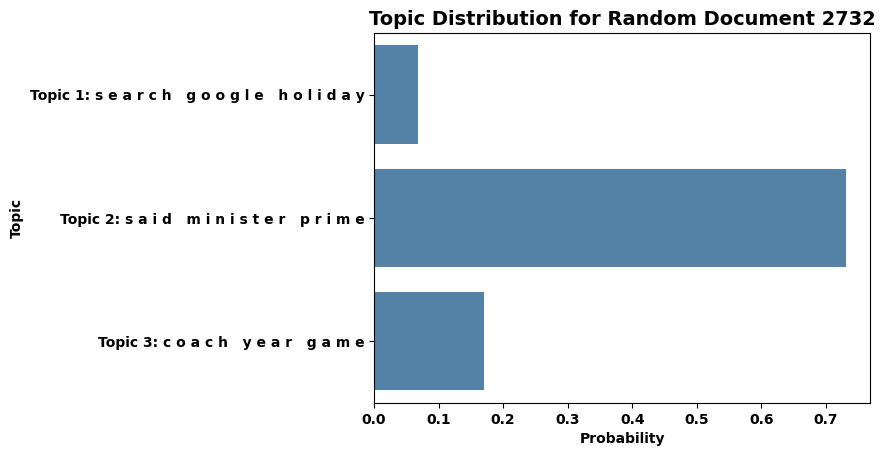

In [26]:
# Pick a random document in test set
# Check which "topics" are associated with it
np.random.seed(0)
doc_index = np.random.choice(len(test_df))
doc_topics = test_doc_topics[doc_index]
topic_probabilities = [probability for _, probability in doc_topics]

n_topics = len(topic_probabilities)

# Include both topic number and representative words in ytick labels
topic_names_with_words = [f"Topic {i+1}: {' '.join(words)}" for i, words in enumerate(get_topic_names(lda_model, n_words=3))]

# Create a DataFrame from the topic names and probabilities
data = pd.DataFrame({"Topic": topic_names_with_words[:n_topics], "Probability": topic_probabilities})

# Create the bar plot
sns.barplot(x="Probability", y="Topic", data=data, orient='h', color='steelblue')

# Set the title
plt.title(f"Topic Distribution for Random Document {doc_index}", fontsize=14)

plt.show()

**5. Conclusions**

- After performing exploratory data analysis, it was revealed that the dataset is well-balanced. Additionally, the mean values for title and description lengths were found to be 42 and 193, respectively.

- Based on the results of the topic modeling, the most probable topics in the train set were identified as topics #2, 4, 7, and 9.

- The log-likelihood value of -11.212 and perplexity value of 2372.962 obtained from the topic model indicate that there is still room for improvement. One potential approach to enhance the model's performance is to closely examine the top words associated with each topic and assess their coherence to ensure that they make sense together.

- The trained model was tested on the test corpus, and it showed reasonable prediction of three topic words in a topic.